In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense


# =====================================================
# 1. Load Dataset (your file)
# =====================================================
with open("/kaggle/input/gujarati/gu_sample.txt", "r", encoding="utf-8") as f:
    corpus = f.read().split("\n")


# =====================================================
# 2. Reduce Corpus (prevents RAM crash)
# =====================================================
MAX_LINES = 50000       # safe for Colab
corpus = corpus[:MAX_LINES]
print("Lines used:", len(corpus))


# =====================================================
# 3. Tokenization
# =====================================================
tokenizer = Tokenizer(num_words=4352)   # force vocabulary to ≈4352
tokenizer.fit_on_texts(corpus)

vocab_size = 4352
print("Vocabulary Size:", vocab_size)


# =====================================================
# 4. Build Input Sequences (Safe Version)
# =====================================================
MAX_ALLOWED_LEN = 40      # prevents huge padding
MAX_TRAIN_SAMPLES = 200000   # prevents RAM explosion

input_sequences = []
count = 0

for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]

    # Limit long sentences
    if len(token_list) > MAX_ALLOWED_LEN:
        token_list = token_list[:MAX_ALLOWED_LEN]

    # Build n-gram sequences
    for i in range(1, len(token_list)):
        ngram = token_list[:i+1]
        input_sequences.append(ngram)
        count += 1
        
        if count >= MAX_TRAIN_SAMPLES:
            break
    if count >= MAX_TRAIN_SAMPLES:
        break

print("Total training sequences:", len(input_sequences))


# =====================================================
# 5. Padding
# =====================================================
max_sequence_len = max([len(x) for x in input_sequences])
print("Max Sequence Length:", max_sequence_len)

input_sequences = pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre')

input_sequences = np.array(input_sequences)

X = input_sequences[:, :-1]
y = input_sequences[:, -1]   # sparse labels (no one-hot)


# =====================================================
# 6. Define Model (Optimized)
# =====================================================
embedding_dim = 4
gru_units = 512

model = Sequential()

model.add(Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    input_shape=(max_sequence_len - 1,)   # FIXED
))

model.add(GRU(gru_units))

model.add(Dense(vocab_size, activation='softmax'))

model.summary()


# =====================================================
# 7. Compile
# =====================================================
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)


# =====================================================
# 8. Train
# =====================================================
history = model.fit(
    X, y,
    epochs=25,
    batch_size=32,       # safe batch size
    verbose=1
)


2025-11-20 05:46:03.951416: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763617564.343713      48 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763617564.456735      48 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

Lines used: 50000
Vocabulary Size: 4352
Total training sequences: 200000
Max Sequence Length: 40


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
I0000 00:00:1763617590.284155      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1763617590.284835      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 39, 4)          │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 512)            │       795,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4352)           │     2,232,576 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,045,632 (11.62 MB)

 Trainable params: 3,045,632 (11.62 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25


I0000 00:00:1763617594.445944     111 cuda_dnn.cc:529] Loaded cuDNN version 90300


6250/6250 ━━━━━━━━━━━━━━━━━━━━ 52s 8ms/step - accuracy: 0.0676 - loss: 6.9789
Epoch 2/25
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 50s 8ms/step - accuracy: 0.1067 - loss: 6.2043
Epoch 3/25
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 50s 8ms/step - accuracy: 0.1186 - loss: 5.9112
Epoch 4/25
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 51s 8ms/step - accuracy: 0.1286 - loss: 5.5852
Epoch 5/25
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 51s 8ms/step - accuracy: 0.1467 - loss: 5.1847
Epoch 6/25
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 51s 8ms/step - accuracy: 0.1772 - loss: 4.7450
Epoch 7/25
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 51s 8ms/step - accuracy: 0.2178 - loss: 4.3309
Epoch 8/25
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 51s 8ms/step - accuracy: 0.2626 - loss: 3.9686
Epoch 9/25
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 51s 8ms/step - accuracy: 0.2998 - loss: 3.6792
Epoch 10/25
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 51s 8ms/step - accuracy: 0.3348 - loss: 3.4392
Epoch 11/25
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 51s 8ms/step - accuracy: 0.3606 - loss: 3.2737
Epoch 12/25
6250/6250 ━━━━━━━━

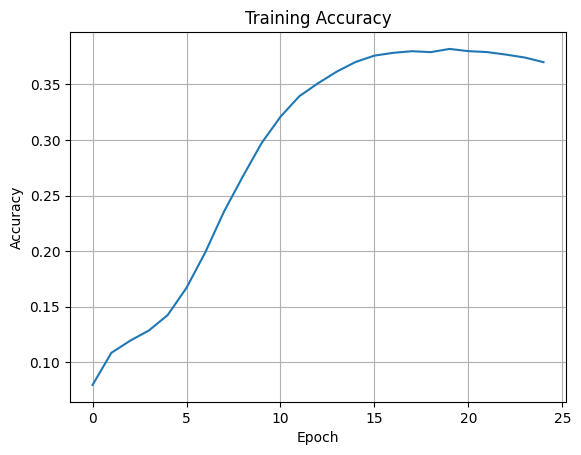

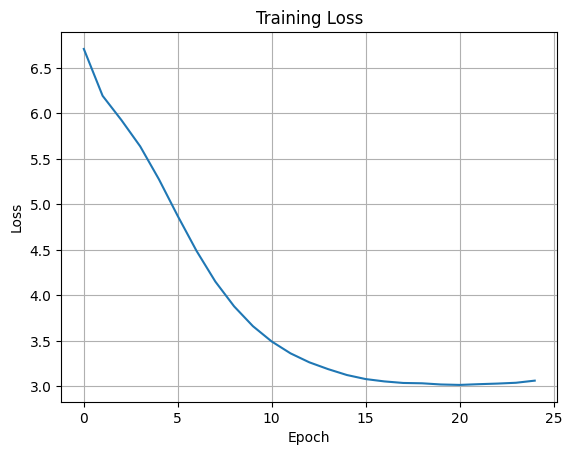

In [3]:
import matplotlib.pyplot as plt

# -----------------------------
# Accuracy Plot
# -----------------------------
plt.plot(history.history['accuracy'])
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.savefig("/kaggle/working/accuracy_plot.png")
plt.show()

# -----------------------------
# Loss Plot
# -----------------------------
plt.plot(history.history['loss'])
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.savefig("/kaggle/working/loss_plot.png")
plt.show()


In [4]:
model.save("/kaggle/working/gujarati_nextword_model.keras")
print("Model saved successfully!")

Model saved successfully!


In [5]:
# -----------------------------
# 9. Prediction Function
# -----------------------------
def predict_next_word(seed_text, max_sequence_len=max_sequence_len):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted = model.predict(token_list, verbose=0)

    predicted_index = np.argmax(predicted)
    for word, index in tokenizer.word_index.items():
        if index == predicted_index:
            return word

    return ""

# -----------------------------
# 10. Test Prediction
# -----------------------------
print("\nNext word:", predict_next_word("આ પુસ્તકમાં ભારત અને વિદેશના ક્રિકેટ વિશે લખવામાં"))


Next word: આવ્યું
